In [1]:
import math
import os
import random

from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np


In [2]:
%matplotlib inline

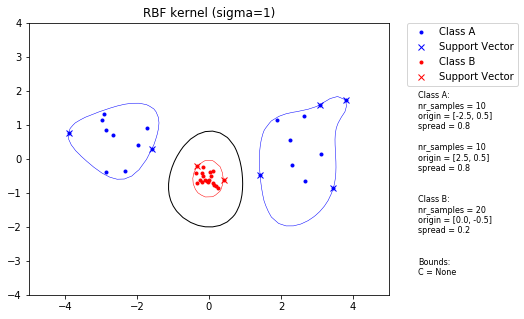

In [18]:
def b():
    """ Calculate bias for ind()
    Implementation of formula (7). Iterates only through support vectors because alpha is zero for all others.
    """
    return sum(SVs['a'][i] * SVs['t'][i] * K(SVs['x'][0], SVs['x'][i]) for i in range(len(SVs['a']))) - SVs['t'][0]


def ind(s):
    """ Indicator function
    Implementation of formula (6). Classifier for argument vector s. Iterates only through support vectors because alpha
    is zero for all others.
    """
    return sum(SVs['a'][i] * SVs['t'][i] * K(s, SVs['x'][i]) for i in range(len(SVs['a']))) - b()


def K(x, y):
    """ Kernel function
    By utilizing the kernel trick it's possible to transform the input data to a higher dimensions by only calculating
    the scalar product of phi(x) and phi(y). This allows the creation of more complex boundaries.
    """
    if kernel_params['type'].lower() == 'lin':  # Linear
        return np.dot(x, y)
    elif kernel_params['type'].lower() == 'poly':  # Polynomial
        return pow((np.dot(x, y) + 1), kernel_params['p'])
    elif kernel_params['type'].lower() == 'rbf':  # Radial Basis Function
        return math.exp(- pow(np.linalg.norm(x - y), 2) / (2 * pow(kernel_params['sigma'], 2)))
    else:
        raise ValueError('Kernel type not found...')


def objective(alpha):
    """ Dual formulation from (4)
    Takes a vector alpha and returns a scalar value. Used by minimize().
    """
    double_sum = 0
    for i in range(N):
        for j in range(N):
            double_sum += alpha[i] * alpha[j] * P[i, j]

    return 0.5 * double_sum - np.sum(alpha)


def plot():
    """ Plot graph
    Includes class A and B samples and draws the generated decision boundary. Parameters used are shown on the right
    hand side of the figure.
    """
    fig, ax = plt.subplots(figsize=(8, 5))
    fig.subplots_adjust(right=0.75)

    ax.plot([p[0] for p in classA], [p[1] for p in classA], 'b.', label='Class A')
    lst = [p for p in SVs['x'] if p in classA]
    ax.plot([p[0] for p in lst], [p[1] for p in lst], 'bx', label='Support Vector')

    ax.plot([p[0] for p in classB], [p[1] for p in classB], 'r.', label='Class B')
    lst = [p for p in SVs['x'] if p in classB]
    ax.plot([p[0] for p in lst], [p[1] for p in lst], 'rx', label='Support Vector')

    xgrid = np.linspace(-5, 5)
    ygrid = np.linspace(-4, 4)
    grid = np.array([[ind([x, y]) for x in xgrid] for y in ygrid])
    ax.contour(xgrid, ygrid, grid, (-1.0, 0.0, 1.0), colors=('red', 'black', 'blue'), linewidths=(0.5, 1.0, 0.5))

    leg = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

    # Need to draw the canvas to be able to read final coordinates in pixels.
    fig.canvas.draw()
    leg_pxls = leg.get_window_extent()
    ax_pxls = ax.get_window_extent()
    fig_pxls = fig.get_window_extent()

    # Converting back to figure normalized coordinates to create new axis.
    pad = 0.025
    ax2 = fig.add_axes([leg_pxls.x0 / fig_pxls.width,
                        ax_pxls.y0 / fig_pxls.height,
                        leg_pxls.width / fig_pxls.width,
                        (leg_pxls.y0 - ax_pxls.y0) / fig_pxls.height - pad])

    ax2.axis('off')

    if kernel_params['type'].lower() == 'lin':
        ax.set_title('Linear kernel')
    elif kernel_params['type'].lower() == 'poly':
        ax.set_title('Polynomial kernel (p={})'.format(kernel_params['p']))
    elif kernel_params['type'].lower() == 'rbf':
        ax.set_title('RBF kernel (sigma={})'.format(kernel_params['sigma']))

    text = 'Class A:\n'
    for i in range(len(classA_params['nr_samples'])):
        text += 'nr_samples = {}\n'.format(classA_params['nr_samples'][i])
        text += 'origin = {}\n'.format(classA_params['origin'][i])
        text += 'spread = {}\n\n'.format(classA_params['spread'][i])
    text += '\nClass B:\n'
    text += 'nr_samples = {}\n'.format(classB_params['nr_samples'])
    text += 'origin = {}\n'.format(classB_params['origin'])
    text += 'spread = {}\n\n'.format(classB_params['spread'])
    text += '\nBounds:\n'
    text += 'C = {}'.format(C_param)

    ax2.text(0.1, 0.1, text, fontsize=8)

    # Increment number to end of filename to not overwrite previously saved file.
    counter = 0
    filename = 'svmplot{}.png'
    while os.path.isfile(filename.format(counter)):
        counter += 1
    plt.savefig(filename.format(counter), bbox_inches='tight')

    plt.show()


def zerofun(alpha):
    """ Constraint for minimize()
    Implementation of the second constraint from (10).
    """
    return sum([alpha[i] * t[i] for i in range(N)])


if __name__ == '__main__':

    np.random.seed(100)

    kernel_params = {'type': 'rbf', 'p': 2, 'sigma': 1}

    classA_params = {'nr_samples': [10, 10], 'origin': [[-2.5, 0.5], [2.5, 0.5]], 'spread': [0.8, 0.8]}
    classB_params = {'nr_samples': 20, 'origin': [0.0, -0.5], 'spread': 0.2}

    C_param = None

    classA = np.concatenate((
        np.random.randn(classA_params['nr_samples'][0], 2) * classA_params['spread'][0] + classA_params['origin'][0],
        np.random.randn(classA_params['nr_samples'][1], 2) * classA_params['spread'][1] + classA_params['origin'][1]))
    classB = np.random.randn(classB_params['nr_samples'], 2) * classB_params['spread'] + classB_params['origin']

    inputs = np.concatenate((classA, classB))
    targets = np.concatenate((np.ones(classA.shape[0]), -np.ones(classB.shape[0])))

    N = inputs.shape[0]  # Number of rows (samples)

    permute = list(range(N))
    random.shuffle(permute)
    x = inputs = inputs[permute, :]
    t = targets = targets[permute]

    start = np.zeros(N)  # Initialise alpha vector
    C = C_param  # Upper bound for alpha. For no upper bound, C = None.
    bounds = [(0, C) for n in range(N)]  # Bounds for each alpha element, 0 <= alpha <= C.
    XC = {'type': 'eq', 'fun': zerofun}

    # To improve efficiency some of the calculations are done in advance and stored in matrix P.
    P = np.ndarray(shape=(N, N))
    for i in range(N):
        for j in range(N):
            P[i, j] = t[i] * t[j] * K(x[i], x[j])

    ret = minimize(objective, start, bounds=bounds, constraints=XC)
    alpha = ret['x']
    alpha = np.array([round(a, 5) for a in alpha])  # Zero out the almost alphas which are almost zero.

    # Save alpha, x and t to dictionary when alpha != 0, i.e. save information for support vectors.
    SVs = {'a': [], 'x': [], 't': []}
    for i in range(N):
        if alpha[i]:
            SVs['a'].append(alpha[i])
            SVs['x'].append(x[i])
            SVs['t'].append(t[i])

    plot()